<a href="https://colab.research.google.com/github/liang-faan/python-ml/blob/main/USML_4_DL_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jun 11 07:18:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    35W / 250W |    929MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Basics of PyTorch modeling
Here, I will outline the major components of a Deep Learning model.

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms

Step 0: Load the dataset

In [ ]:
# Let's download the data first
dataset = datasets.MNIST('data', download=True, train=True, transform=transforms.ToTensor())

# The dataset is split into X (image) and y (label)
# Here we check the first image
# (which is an image of 28 by 28 pixels with the label 5)
dataset[0]

In [ ]:
# Separate the image from the label
img_batch, label = dataset[0]

In [ ]:
# .shape is an important method that we use to inspect the
# dimensions of a data sample

# Here, we have 1 sample with 28 x 28 pixels
# The first number indicates batch size.
# We usually process a number of samples at a time, so if we
# take 32 samples per batch, then each img_batch will have the
# shape (32, 28, 28)
img_batch.shape

torch.Size([1, 28, 28])

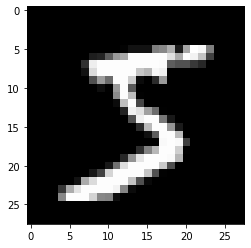

In [ ]:
# Let's print the first image to see what it looks like.
# The first image is indexed 0 in the batch.

plt.imshow(img_batch[0], cmap='gray')

In [ ]:
# Now let's split the entire dataset into train and validation set
train, val = random_split(dataset, [55000, 5000])

In [ ]:
# Loading data in PyTorch and Tensorflow is done via special classes
# DataLoaders makes it easier to work with data across the pipeline
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

### Step 1: Define a model architecture
Using sequential means a fully connected neural network where all sucessive nodes are connected to the nodes in the previous layer.

Let's try using it to predict images with dimension 28 by 28 using a multi-layer perceptron.

In [ ]:
# Note that the tensor separates the image into a matrix that is 28 by 28
# For images, each pixel is a feature, therefore, we can represent each image
# with 28 x 28 = 784 features.

model = nn.Sequential(
    nn.Linear(28 * 28, 64),  # (input dimension, output dimension) << input layer
    nn.ReLU(),
    nn.Linear(64, 64),  # (input dimension, output dimension)  << hidden layer
    nn.ReLU(),
    nn.Linear(64, 10)  # (input dimension, output dimension) << output layer (10 classes)
)

What are activation functions? https://mlfromscratch.com/activation-functions-explained/#/

### Step 2: Define an optimizer

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)

What are optimizers? https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c

### Step 3: Define loss function

In [ ]:
loss = nn.CrossEntropyLoss()

### Step 4: Define training loops

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    train_losses = list()
    train_accuracy = list()
    for batch in train_loader:
        x, y = batch  # In a dataloader, x is the data and y is the label

        # From a dataloader, x is of the shape (batch, channels, dimensions)
        # Example (32, 1, 784): Recall that 784 is 28 x 28 which is the image.
        # Since we only have 1 channel, we can remove it to make it (32, 784)
        b = x.size(0)
        x = x.view(b, -1)

        # Step 1: Forward the input feature values through the network
        logits = model(x)

        # Step 2: Compute the objective function
        J = loss(logits, y)

        # Step 3: Clean any previous accumulated gradients by setting it to 0
        model.zero_grad()  # This is like setting params.grad to zero

        # Step 4: Accumulate the partial derivatives of J wrt parameters
        J.backward()  # This is like summing params.grad with (dJ/dparams)

        # Step 5: Apply a step in the opposite direction of the gradient
        optimizer.step()  # This is like params = params - learning_rate * params.grad

        train_losses.append(J.item())
        train_accuracy.append(y.eq(logits.argmax(dim=1)).float().mean())

    val_losses = list()
    val_accuracy = list()
    for batch in val_loader:
        x, y = batch  # In a dataloader, x is the data and y is the label

        # From a dataloader, x is of the shape (batch, channels, dimensions)
        b = x.size(0)
        x = x.view(b, -1)

        # Forward the input feature values through the network
        # ## Since validation don't update weights, we don't need to load the
        # ## gradients
        with torch.no_grad():
            logits = model(x)

        # Compute the objective function
        J = loss(logits, y)

        val_losses.append(J.item())
        val_accuracy.append(y.eq(logits.argmax(dim=1)).float().mean())

    print(f'Epoch {epoch + 1}, train loss: {torch.tensor(train_losses).mean():.2f}, val loss: {torch.tensor(val_losses).mean():.2f}')
    print(f'        train acc: {torch.tensor(train_accuracy).mean():.2f}, val acc: {torch.tensor(val_accuracy).mean():.2f}')

Epoch 1, train loss: 1.23, val loss: 0.48
        train acc: 0.64, val acc: 0.86
Epoch 2, train loss: 0.41, val loss: 0.34
        train acc: 0.89, val acc: 0.90
Epoch 3, train loss: 0.33, val loss: 0.29
        train acc: 0.91, val acc: 0.91
Epoch 4, train loss: 0.28, val loss: 0.26
        train acc: 0.92, val acc: 0.92
Epoch 5, train loss: 0.25, val loss: 0.23
        train acc: 0.93, val acc: 0.93
Epoch 6, train loss: 0.23, val loss: 0.21
        train acc: 0.93, val acc: 0.94
Epoch 7, train loss: 0.21, val loss: 0.20
        train acc: 0.94, val acc: 0.94
Epoch 8, train loss: 0.19, val loss: 0.19
        train acc: 0.95, val acc: 0.94
Epoch 9, train loss: 0.18, val loss: 0.18
        train acc: 0.95, val acc: 0.95
Epoch 10, train loss: 0.17, val loss: 0.17
        train acc: 0.95, val acc: 0.95
Epoch 11, train loss: 0.16, val loss: 0.16
        train acc: 0.95, val acc: 0.95
Epoch 12, train loss: 0.15, val loss: 0.15
        train acc: 0.96, val acc: 0.95
Epoch 13, train loss: 0.1

As the number of epochs grow, the training and validation accuracy will increase until a point where the validation accuracy will start to fall. This is the point where overfitting happens.

If overfitting occurs after an acceptable validation accuracy, then we can simply stop the training at the epoch number right before overfitting happens.

What if we have not achieved the acceptable validation accuracy? In this case we need to perform some overfitting techniques.
> The most common one is the dropout, which randomly sets some node values to zero.
>
> This is very similar to bagging ensembles, where each model sees only a subset of values and features.
>
> In deep learning, each epoch is a small model. Successive epochs adjusts the weights of the previous to get better accuracy. Dropout adds the bagging mechanism to this.

In the next section, we will implement the dropout. But let's class the model to make it easier to maintain.
> This class is also the default way to construct PyTorch models.

Because we are switching models, please remember to restart your colab instance!
> Go to the menu bar and click Runtime > Restart Runtime.
>
> Then load all the imports, data, and dataloader codes.

In [ ]:
class ImageNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h1 = nn.functional.relu(self.l1(x))
        h2 = nn.functional.relu(self.l2(h1))
        dropout = self.dropout(h2)
        # dropout = self.dropout(h2 + h1)  # This is known as a residual connection
        logits = self.l3(dropout)
        return logits

We are also going to utilize GPU. Always remember:
1. The model and data must both reside in the same computational device, i.e. both on CPU or both on GPU.
> Data refers to both the X and the y.
2. To switch between CPU and GPU, we use the .to() method.
> model.to('cuda') or model.to('cpu')
>
> x.to('cuda') or x.to('cpu')
>
> y.to('cuda') or y.to('cpu')

In [ ]:
# Call the model and load it into the GPU
model = ImageNN()
model.to('cuda')

ImageNN(
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# Define optimizer
# Here we use a more efficient optimizer called the Adam, see how fast it
# reaches the minimum loss.
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Define loss
loss = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 30
for epoch in range(num_epochs):

    train_losses = list()
    train_accuracy = list()
    model.train()

    for batch in train_loader:
        x, y = batch  # In a dataloader, x is the data and y is the label

        # From a dataloader, x is of the shape (batch, channels, dimensions)
        # Example (32, 1, 784): Recall that 784 is 28 x 28 which is the image.
        # Since we only have 1 channel, we can remove it to make it (32, 784)
        b = x.size(0)
        x = x.view(b, -1).to('cuda')
        y = y.to('cuda')

        # Step 1: Forward the input feature values through the network
        logits = model(x)

        # Step 2: Compute the objective function
        J = loss(logits, y)

        # Step 3: Clean any previous accumulated gradients by setting it to 0
        model.zero_grad()  # This is like setting params.grad to zero

        # Step 4: Accumulate the partial derivatives of J wrt parameters
        J.backward()  # This is like summing params.grad with (dJ/dparams)

        # Step 5: Apply a step in the opposite direction of the gradient
        optimizer.step()  # This is like params = params - learning_rate * params.grad

        train_losses.append(J.item())
        train_accuracy.append(y.eq(logits.argmax(dim=1)).float().mean())

    val_losses = list()
    val_accuracy = list()
    model.eval()

    for batch in val_loader:
        x, y = batch  # In a dataloader, x is the data and y is the label

        # From a dataloader, x is of the shape (batch, channels, dimensions)
        b = x.size(0)
        x = x.view(b, -1).to('cuda')
        y = y.to('cuda')

        # Forward the input feature values through the network
        # ## Since validation don't update weights, we don't need to load the
        # ## gradients
        with torch.no_grad():
            logits = model(x)

        # Compute the objective function
        J = loss(logits, y)

        val_losses.append(J.item())
        val_accuracy.append(y.eq(logits.argmax(dim=1)).float().mean())

    print(f'Epoch {epoch + 1}, train loss: {torch.tensor(train_losses).mean():.2f}, val loss: {torch.tensor(val_losses).mean():.2f}')
    print(f'         train acc: {torch.tensor(train_accuracy).mean():.3f}, val acc: {torch.tensor(val_accuracy).mean():.3f}')

Epoch 1, train loss: 0.28, val loss: 0.23
         train acc: 0.918, val acc: 0.935
Epoch 2, train loss: 0.19, val loss: 0.21
         train acc: 0.948, val acc: 0.948
Epoch 3, train loss: 0.16, val loss: 0.21
         train acc: 0.956, val acc: 0.950
Epoch 4, train loss: 0.15, val loss: 0.18
         train acc: 0.960, val acc: 0.957
Epoch 5, train loss: 0.14, val loss: 0.19
         train acc: 0.963, val acc: 0.953
Epoch 6, train loss: 0.13, val loss: 0.20
         train acc: 0.966, val acc: 0.961
Epoch 7, train loss: 0.12, val loss: 0.22
         train acc: 0.969, val acc: 0.956
Epoch 8, train loss: 0.12, val loss: 0.19
         train acc: 0.969, val acc: 0.960
Epoch 9, train loss: 0.12, val loss: 0.20
         train acc: 0.971, val acc: 0.958
Epoch 10, train loss: 0.11, val loss: 0.19
         train acc: 0.972, val acc: 0.967
Epoch 11, train loss: 0.11, val loss: 0.21
         train acc: 0.973, val acc: 0.965
Epoch 12, train loss: 0.10, val loss: 0.17
         train acc: 0.975, val 